In [734]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
from tqdm import tqdm
from scipy.stats import lognorm

# 3) Propagation d’incertitudes

### Question 1 : Programmation de la résolution du système (1) avec t0 = 1900 (l’unité de temps est l’année).

Pour la résolution du système, nous avons choisi d'implémenter et de comparer deux méthodes de résolution numérique : la méthode d'Euler et celle de Runge-Kutta d'ordre 4. </br>
On applique ces deux méthodes pour résoudre le système différentiel couplé $(y,z)$ donné par le modèle de Lotka-Volterra défini par l'équation (1) du sujet.

#### A. Méthode d'Euler (explicite):
Cette méthode est basée sur l'approximation de la solution en utilisant la pente de la tangente à chaque étape, c'est-à-dire en utilisant la dérivée de la solution à chaque point.

Les étapes sont les suivantes :

i) Discrétisation du temps : on choisit un pas de temps dt et on divise l'intervalle de temps d'intérêt en N sous-intervalles de longueur dt. </br>
ii) Initialisation : on utilise les valeurs initiales $y_{0}$ et $z_{0}$ pour les solutions $y(t)$ et $z(t)$ au temps $t=0$. </br>
iii) Itération : on calcule les valeurs de $y(t)$ et $z(t)$ pour chaque étape i en utilisant les formules suivantes : </br>
${ y_{i+1} = y_{i} + dt *f(t_{i},y_{i},z_{i}), i \in \{0,N-1\} }$
</br>
${ z_{i+1} = z_{i} + dt *g(t_{i},y_{i},z_{i}), i \in \{0,N-1\} }$
</br>
avec f et g les fonctions au second membres dans le modèle de Lotka-Volterra.

In [735]:
def resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,dt,N,t0=1900.0):
    '''
    Cette fonctipn permet de résoudre le système (1) en utilisant la méthode d'Euler
    '''
    
    temps = np.arange(0,N)*dt+t0  # Par exemple, pour un intervalle de temps de 10 années : dt=10/(N-1)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
        z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))

    return temps,np.array(y,dtype=np.float64),np.array(z,dtype=np.float64)

#### B. Méthode de Runge-Kutta d'ordre 4:

La méthode RK4 est donnée par les équations :
</br>
$k_{1} = f \left(t_{i}, y_{i}, z_{i} \right) $
</br>
$k_{2} = f \left(t_{i} + \frac{dt}{2}, y_{i} + \frac{dt}{2} *k_{1}, z_{i} + \frac{dt}{2} *k_{1}\right) $
</br>
$k_{3} = f \left(t_{i} + \frac{dt}{2}, y_{i} + \frac{dt}{2} *k_{2}, z_{i} + \frac{dt}{2} *k_{2}\right) $
</br>
$k_{4} = f \left(t_{i} + dt, y_{i} + dt *k_{3}, z_{i} + dt*k_{3} \right) $
</br>
$y_{i+1} = y_{i} + \frac{dt}{6} *f(k_{1}+2k_{2}+2k_{3}+k_{4}), i \in \{0,N-1\} $
</br>
Avec f la fonction au second membre pour y dans le modèle de Lotka-Volterra.
</br>
</br>
La même procédure est effectuée en parallèle pour calculer z.

In [736]:
def h(y,z,alpha,beta,delta,gamma) :
    return y*(alpha-beta*z),z*(delta*y-gamma)

In [737]:
def resolutionSystem1EulerRK4(alpha,beta,delta,gamma,y0,z0,dt,N,t0=1900.0):
    '''
    Cette fonctipn permet de résoudre le système (1) en utilisant la méthode de Runge-Kutta d'ordre 4
    '''
    
    temps = np.arange(0,N)*dt+t0 # Par exemple, pour un intervalle de temps de 10 années : dt=10/(N-1)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        k1 = h(y[i],z[i],alpha,beta,delta,gamma)
        k2 = h(y[i]+0.5*dt*k1[0],z[i]+0.5*dt*k1[1],alpha,beta,delta,gamma)
        k3 = h(y[i]+0.5*dt*k2[0],z[i]+0.5*dt*k2[1],alpha,beta,delta,gamma)
        k4 = h(y[i]+dt*k3[0],z[i]+dt*k3[1],alpha,beta,delta,gamma)
        y.append(y[i]+(dt/6)*(k1[0]+2*k2[0]+2*k3[0]+k4[0]))
        z.append(z[i]+(dt/6)*(k1[1]+2*k2[1]+2*k3[1]+k4[1]))

    return temps,np.array(y,dtype=np.float64),np.array(z,dtype=np.float64)

### Question 2 : Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d’entrée de la table 1), représentez la loi des populations de proies et prédateurs en 1900, en 1901 et en 1920.

Pour générer des échantillons des lois lognormales pour les six paramètres d'entrée, on calcule les paramètres moyenne $\lambda$ et variance $\zeta$ des lois normales associées.
Nous disposons déjà de ces paramètres pour les variables  $y_{0}$ et $z_{0}$. Pour $\alpha$, $\beta$, $\delta$ et $\gamma$, nous les calculons à partir de ceux de la loi lognormale à l'aide des formules :
</br>
$\zeta = \sqrt{\log (1 + \frac{\sigma^2}{\mu^2})} $
</br>
$\lambda = \log(\mu) - \frac{\zeta^2}{2}$

In [738]:
mu=np.array([0.5,0.05,0.05,0.5])
std =np.array([0.2,0.02,0.02,0.2])
zeta = np.sqrt(np.log(1+(std**2)/mu**2))
lamb = np.log(mu)-(zeta**2)/2


Pour faire l'échantillonnage Monte Carlo, nous générons $N_{samples} = 1000$ échantillons pour les six paramètres d'entrée.

In [739]:
Nsamples = 1000
alpha = np.random.lognormal(lamb[0],zeta[0],Nsamples)
beta = np.random.lognormal(lamb[1],zeta[1],Nsamples)
delta = np.random.lognormal(lamb[2],zeta[2],Nsamples)
gamma = np.random.lognormal(lamb[3],zeta[3],Nsamples)
y0 = np.random.lognormal(np.log(10),1,Nsamples)
z0 = np.random.lognormal(np.log(10),1,Nsamples)

Ensuite, nous résolvons le système différentiel pour chaque échantillon pour avoir les réalisations de $y$ et $z$.
Pour avoir une résolution plus fine sur les solutions, nous raffinons le pas d'échantillonnage en choisissant $N = 1000$ points sur un intervalle de 20 années.

In [740]:
N = 1000
dt = 20/(N-1) # pour trouver l'indice de l'année k=année/dt
solution = resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,dt,N)

In [741]:
bins = [x+ 0.5 for x in range(-1, 100)]

#### La loi des populations de proies et prédateurs en $t_{0}=1900$ :

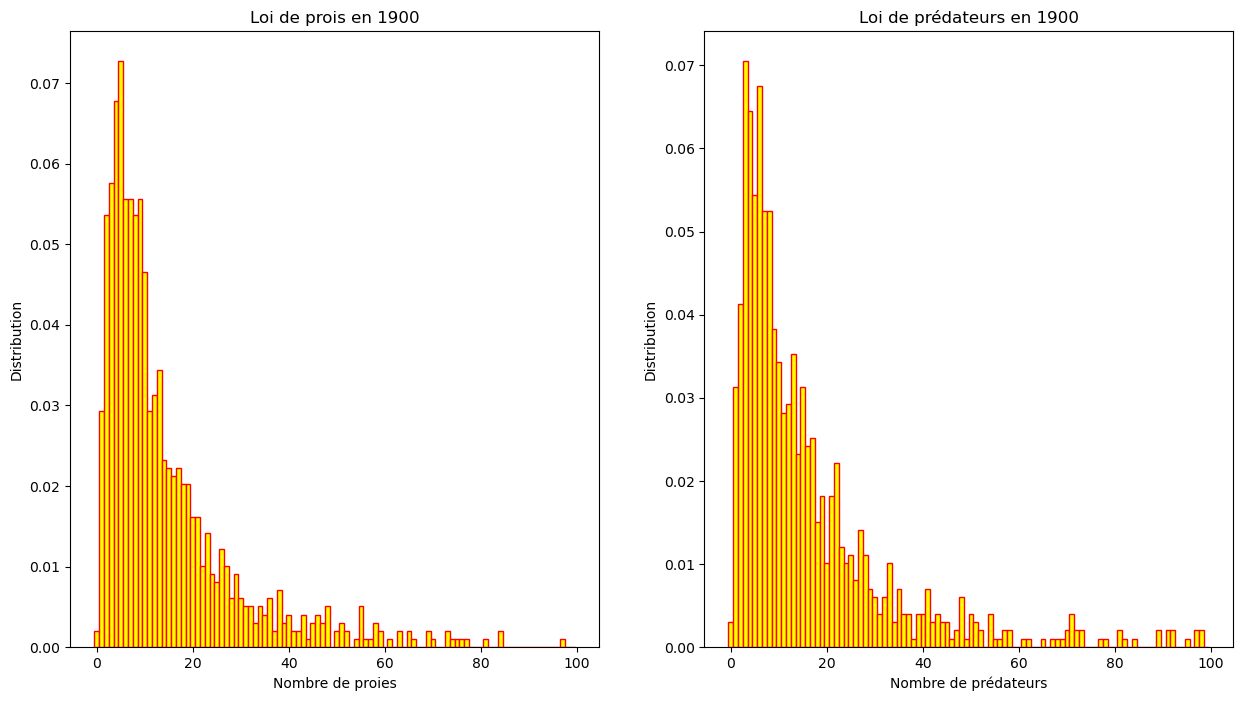

In [742]:
plt.figure(figsize=(15,8),
           facecolor='white')

plt.subplot(1,2,1)
plt.hist(y0,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Distribution')
plt.title('Loi de prois en 1900')

plt.subplot(1,2,2)
plt.hist(z0,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Distribution')
plt.title('Loi de prédateurs en 1900')
plt.show()

#### La loi des populations de proies et prédateurs en $t_{1}=1901$ :

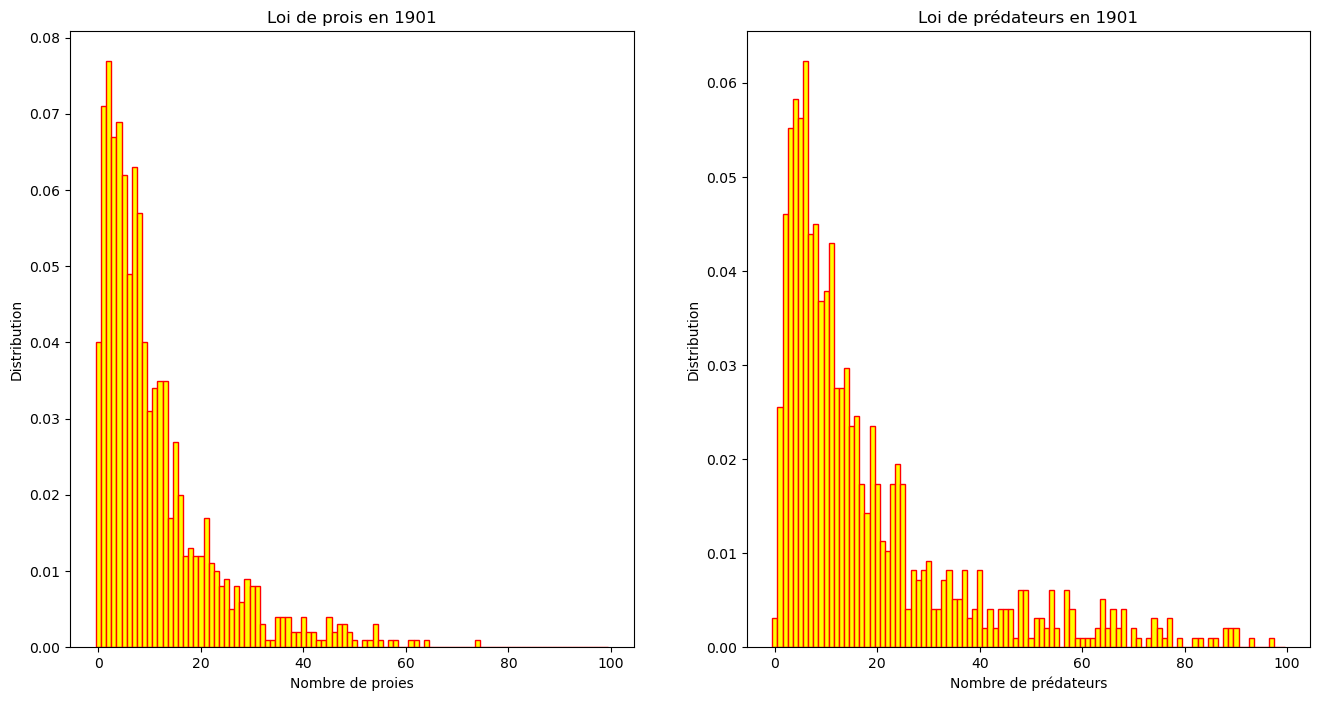

In [743]:
plt.figure(figsize=(16,8),
           facecolor='white')

plt.subplot(1,2,1)
plt.hist(solution[1][int(1/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Distribution')
plt.title('Loi de prois en 1901')

plt.subplot(1,2,2)
plt.hist(solution[2][int(1/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Distribution')
plt.title('Loi de prédateurs en 1901')
plt.show()

#### La loi des populations de proies et prédateurs en $t_{f}=1920$ :

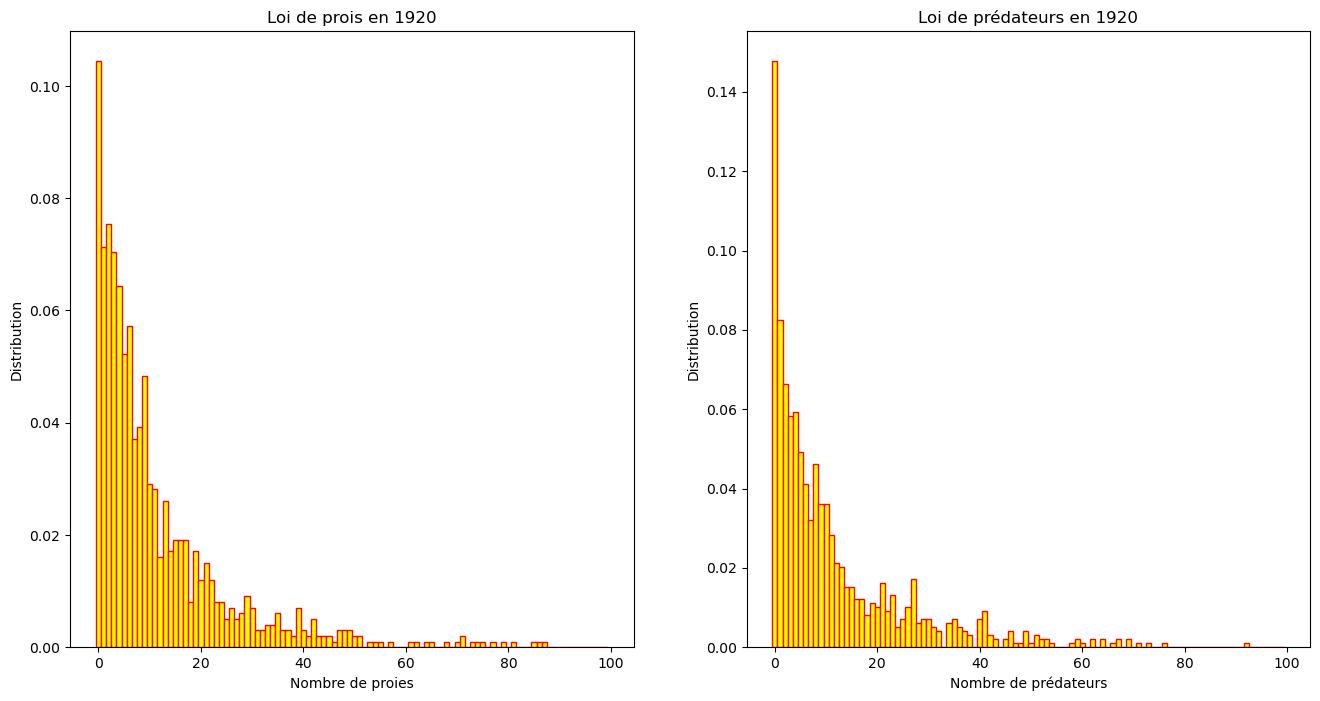

In [744]:
plt.figure(figsize=(16,8),
           facecolor='white')
           
plt.subplot(1,2,1)
plt.hist(solution[1][-1],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Distribution')
plt.title('Loi de prois en 1920')

plt.subplot(1,2,2)
plt.hist(solution[2][-1],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Distribution')
plt.title('Loi de prédateurs en 1920')
plt.show()

#### Le nombre moyen de proies et prédateurs au cours des années : $I_{proie}=E(f(Y))$ , $I_{pred}=E(f(Z))$ :

In [745]:
yto20 = [np.mean(l) for l in solution[1]]

In [746]:
zto20 = [np.mean(l) for l in solution[2]]

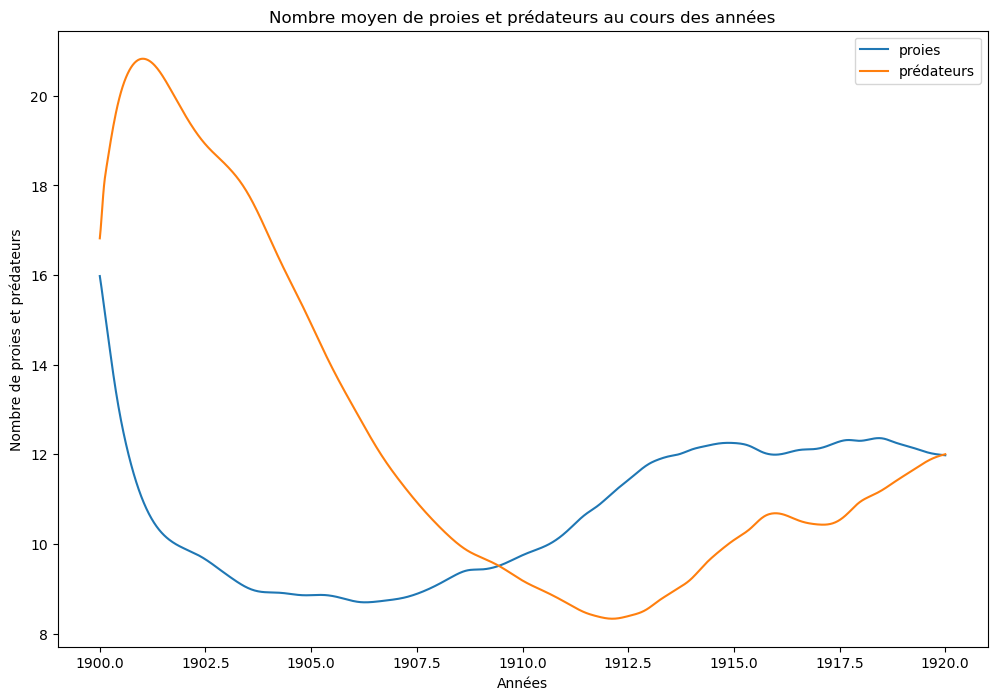

In [748]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(solution[0],yto20, label ="proies")
plt.plot(solution[0],zto20, label ="prédateurs")
plt.xlabel('Années')
plt.ylabel('Nombre de proies et prédateurs')
plt.title('Nombre moyen de proies et prédateurs au cours des années')
plt.legend()
plt.show()

Après avoir étudié ce graphe et analysé les densités précédentes, on peut observer que le nombre de proies diminue brusquement au début tandis que celui des prédateurs augmente. Cette tendance se poursuit jusqu'à ce que le nombre de proies atteigne un seuil minimum vers 1902, à partir duquel leur nombre commence à augmenter lentement tandis que celui des prédateurs diminue rapidement jusqu'en 1911. Ainsi, il est évident que, dans cette première partie, la croissance des prédateurs est étroitement liée à celle des proies. En effet, les prédateurs se nourrissent fortement des proies, ce qui entraîne une diminution abrupte de leur nombre. Cette diminution finit par avoir un impact sur les prédateurs qui se retrouvent avec moins de nourriture, ce qui conduit à une diminution rapide de leur nombre. Pendant ce temps, les proies commencent à se régénérer progressivement après la disparition des prédateurs. Par la suite, la croissance des proies entraîne également une croissance des prédateurs, ce qui finit par avoir un impact sur les proies et ramène la situation à celle du début.
</br>
Ainsi, il existe une périodicité qui sera plus clairement visible sur la prochaine courbe.

# 4) Calibration

### Question 3 : Réprésentation des données collectées de 1900 à 1920 (nous devrions trouver quelque chose qui ressemble à la figure 1 du pdf du sujet).

In [607]:
annee = [1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919,1920]
lievre = [30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7]
lynx = [4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]

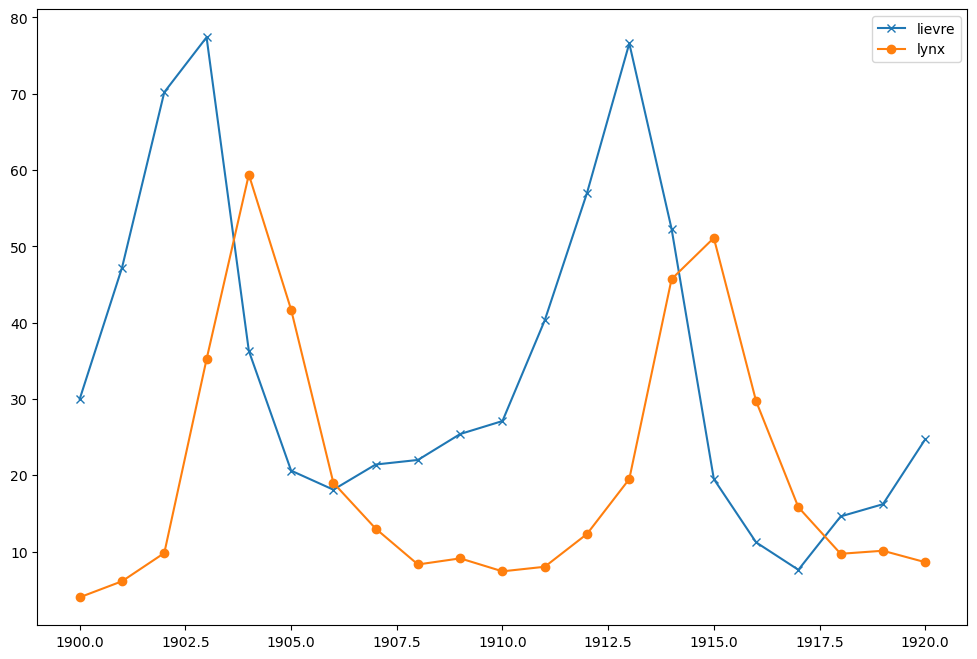

In [608]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(annee,lievre,"-x", label ="lievre")
plt.plot(annee,lynx, "-o",label ="lynx")
plt.legend()
plt.show()

On obtient une figure identique à celle indiquée dans l'énoncé.

### Question 4 : Evaluation numérique de $x^{*}$ dans le domaine de $\mathbb R^{6}$ déterminé par le support essentiel des lois à priori (l’hypercube $\prod_{j=1}^6 [exp(\lambda_{j} - 2\zeta_{j}),exp(\lambda_{j} + 2\zeta_{j})] $ ).

#### Fonction objective à minimiser

In [749]:
def epsilon(x,*args):
    '''
    Fonction objective à minimiser
    '''
    temps,y,z = resolutionSystem1EulerRK4(x[0],x[1],x[2],x[3],x[4],x[5],args[0],args[1])
    dt = args[0]
    ypred = y[[int(k/dt) for k in range(21)]]
    zpred = z[[int(k/dt) for k in range(21)]]
    yresidu = np.log(ypred)-np.log(args[2])
    zresidu = np.log(zpred)-np.log(args[3])
    eps = np.sum(yresidu**2)+np.sum(zresidu**2) 

    return eps 


#### Conditions initiales et bornes de l'hypercube :

In [750]:
x0 = [0.5,0.03,0.03,0.5,3,3] # x0 est dans le hupercub
args = (dt,N,lievre,lynx)
mean_normal = np.array([0.5, 0.05, 0.05, 0.5, np.log(10), np.log(10)])
mean_normal[:4]=lamb
std_normal = np.array([0.2, 0.02, 0.02, 0.2, 1, 1])
std_normal[:4]=zeta
min_bound = np.exp(mean_normal-2*std_normal)
max_bound = np.exp(mean_normal+2*std_normal)
bound = np.concatenate((min_bound, max_bound)).reshape((6,2), order='F')
print("le hupercub = ",bound)


le hupercub =  [[2.14839611e-01 1.00315412e+00]
 [2.14839611e-02 1.00315412e-01]
 [2.14839611e-02 1.00315412e-01]
 [2.14839611e-01 1.00315412e+00]
 [1.35335283e+00 7.38905610e+01]
 [1.35335283e+00 7.38905610e+01]]


#### Résolution du problème de minimisation :

In [757]:
result = minimize(epsilon,x0,args=args,method="Nelder-Mead",bounds= bound) # "SLSQP","Powell"
print("Le minimum de la fonction est :", result['fun'])
x_opt = result['x'] # le point où le minimum est atteint
print("########## le point où le minimum est atteint ############")
print(x_opt)

Le minimum de la fonction est : 2.021286011424579
########## le point où le minimum est atteint ############
[5.39703884e-01 2.71396739e-02 2.36848743e-02 7.95733950e-01
 3.48229952e+01 5.84850530e+00]


Pour les paramètres $\alpha$, $\beta$, $\delta$ et $\gamma$ on trouve des valeurs presque égales à celles de l'article.

In [758]:
print("le resultat de la méthode Nelder-Mead",result)

le resultat de la méthode Nelder-Mead        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.021286011424579
             x: [ 5.397e-01  2.714e-02  2.368e-02  7.957e-01  3.482e+01
                  5.849e+00]
           nit: 696
          nfev: 1074
 final_simplex: (array([[ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.849e+00],
                       [ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.848e+00],
                       ...,
                       [ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.848e+00],
                       [ 5.397e-01,  2.714e-02, ...,  3.482e+01,
                         5.848e+00]]), array([ 2.021e+00,  2.021e+00,  2.021e+00,  2.021e+00,
                        2.021e+00,  2.021e+00,  2.021e+00]))


### Comparaison sur une figure des données $(data_{proie}(t_{i}), data_{pred}(t_{i}))_{i=0}^{20}$ et les prédictions $\mathbb M(x^{*},t)$ :

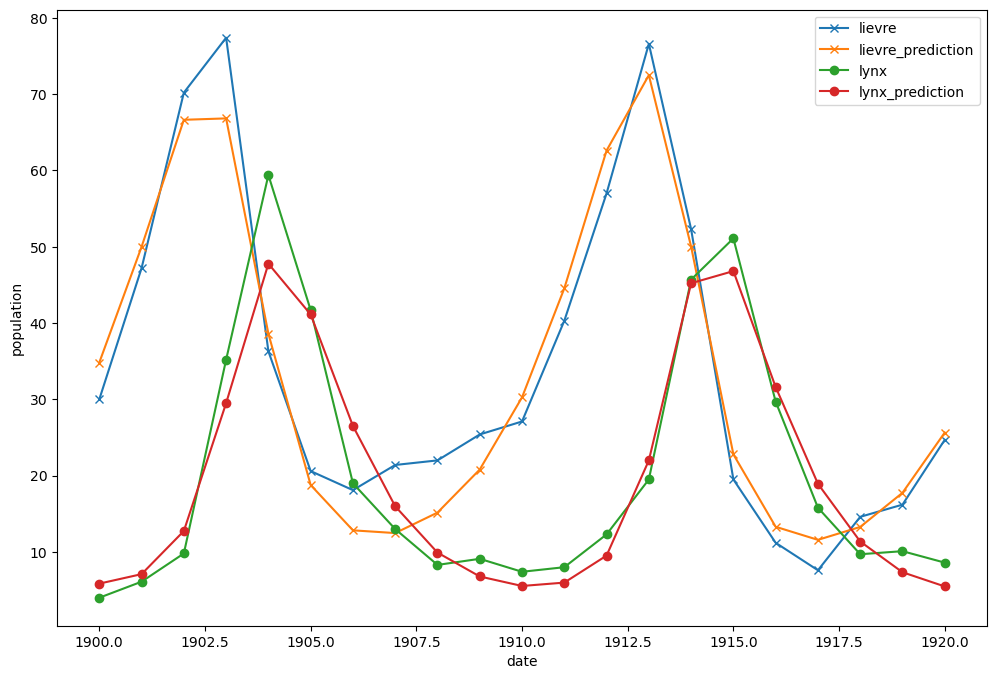

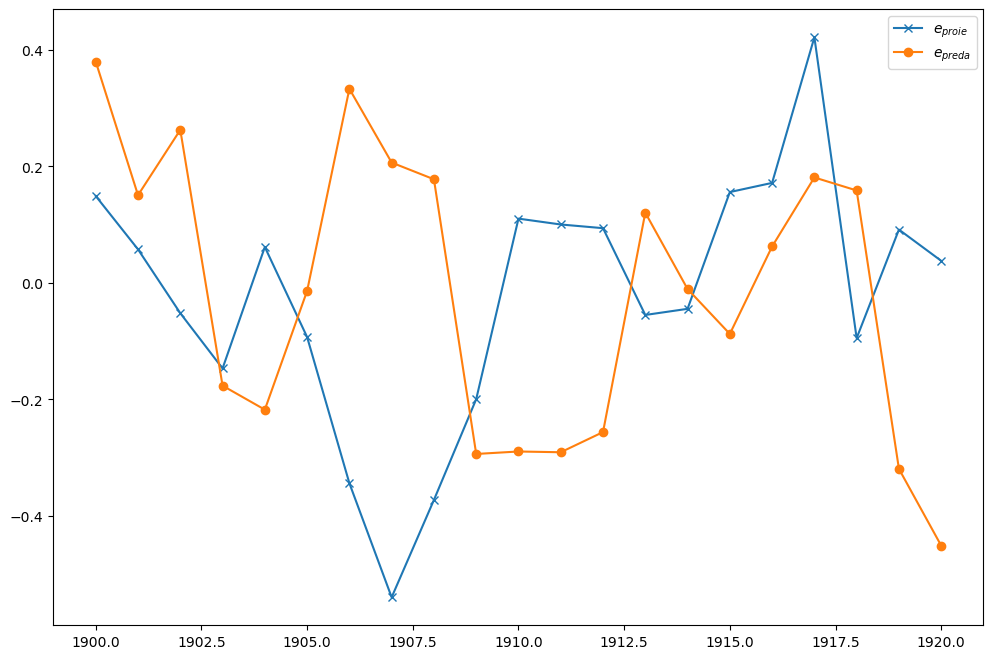

In [756]:
temps,y,z = resolutionSystem1Euler(x_opt[0],x_opt[1],x_opt[2],x_opt[3],x_opt[4],x_opt[5],args[0],args[1])
dt = args[0]
ypred = y[[int(k/dt) for k in range(21)]]
zpred = z[[int(k/dt) for k in range(21)]]
yresidu = np.log(ypred)-np.log(args[2])
zresidu = np.log(zpred)-np.log(args[3])

plt.figure(figsize=(12,8), facecolor='white')
plt.plot(annee,args[2],"-x", label = "lievre")
plt.plot(annee,ypred, "-x",label = "lievre_prediction")
plt.plot(annee,args[3], "-o",label = "lynx")
plt.plot(annee,zpred,"-o",label = "lynx_prediction")
plt.xlabel('date')
plt.ylabel('population')
plt.title('')
plt.legend()
plt.show()

plt.figure(figsize=(12,8), facecolor='white')
plt.plot(annee,yresidu,"-x", label = r'$e_{proie}$')
plt.plot(annee,zresidu, "-o",label = r'$e_{preda}$')
plt.legend()
plt.show()
plt.show()

## 4.2) Calibration bayésienne

### Question 5 : Détermination de l’hyper-paramètre $\sigma$ par une méthode du maximum de vraisemblance :

On a : 
</br>
$
\begin{align}
\sigma^{*} &= \underset{\sigma}{\operatorname{argmax}}  ~~ {p(data|x^{*},\sigma)} \\
           &= \underset{\sigma}{\operatorname{argmax}}  ~~ \frac{1}{(2\pi)^{21} \sigma_{proie}^{21} \sigma_{preda}^{21}} \exp \left[ -\frac{1}{2} \sum_{i=0}^{20} \frac {e_{proie}(x^{*},t_{i})^2}{\sigma_{proie}^2} 
           -\frac{1}{2} \sum_{i=0}^{20} \frac {e_{preda}(x^{*},t_{i})^2}{\sigma_{preda}^2} \right] \\
\end{align}
$

### Question 6

 Estimation de $\sigma^{*}$

In [778]:
sigmaOptProie = np.sqrt((1/21)*np.sum(yresidu**2))
sigmaOptPredateur = np.sqrt((1/21)*np.sum(zresidu**2))
print(sigmaOptProie)
print(sigmaOptPredateur)

0.21122588219580915
0.2400143542072007


In [779]:
def vraisemblance(x, sigmaProie, sigmaPredateur):
    global args
    temps,y,z = resolutionSystem1Euler(x[0],x[1],x[2],x[3],x[4],x[5],args[0],args[1])
    dt = args[0]
    ypred = y[[int(k/dt) for k in range(21)]]
    zpred = z[[int(k/dt) for k in range(21)]]
    yresidu = np.log(ypred)-np.log(args[2]) # aproie
    zresidu = np.log(zpred)-np.log(args[3]) # apreda
    p =  ((2*np.pi)**21)*(sigmaProie**21)*(sigmaPredateur**21)
    e_proie2 = np.sum(yresidu**2)
    e_preda2 = np.sum(zresidu**2)
    p=(1/p)*np.exp(-0.5*(e_proie2/(sigmaProie**2)+e_preda2/(sigmaPredateur**2)))
    return p

In [780]:
def prior(x):
    global mean_normal 
    global std_normal
    p=1
    for i in range(np.size(x)):
        p = p*lognorm.pdf(x=x[i], s=std_normal[i], scale=np.exp(mean_normal[i])) #  les paramètres sont indépendants
    
    return p

In [781]:
def  posteriori(x,sigmaProie, sigmaPredateur):
    p = vraisemblance(x, sigmaProie, sigmaPredateur)*prior(x)
    
    return p
    

## Algorithme de Metropolis-Hastings

In [782]:
def MetropolisHastings(x0,Nsamples,sigmaOptProie,sigmaOptPredateur):
    L=[]
    x = x0
    cov = np.identity(np.size(x0))
    for i in range(Nsamples):
        xprim = np.random.multivariate_normal(x,cov, size = 1)
        xprim.shape=(np.size(x0),)
        ro = 0
        if (all(xprim>0)):
            ro = posteriori(np.array(xprim), sigmaOptProie, sigmaOptPredateur)/posteriori(x, sigmaOptProie, sigmaOptPredateur)
        u = np.random.uniform()
        a=min([1,ro])
        
        if(u<=a):
            x = xprim
        L.append(x)
    return np.array(L)
    

Pour n assez grand, Xn suit la loi de densit ́e p et la mesure empirique n1 ni=1  Xi converge  ́etroitement vers la mesure de densit ́e p (p.s.).
Cf. PC. ??????????? (theoreme érgodique)

In [783]:
## test 
Nsamples =10000
b =1000
SamplesXpost = MetropolisHastings(x_opt,Nsamples ,sigmaOptProie, sigmaOptPredateur)
SamplesXpost = SamplesXpost[b:,]  ## nous ne prenons pas en compte les b premiers échantillons donnés par MetropolisHastings

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3029241697.py:7: RuntimeWarning: invalid value encountered in log
  yresidu = np.log(ypred)-np.log(args[2]) # aproie
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/1517251274.py:10: RuntimeWarning: invalid value encountered in double_scalars
  ro = posteriori(np.array(xprim), sigmaOptProie, sigmaOptPredateur)/posteriori(x, sigmaOptProie, sigmaOptPredateur)
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/2532034969.py:10: RuntimeWarning: overflow encountered in double_scalars
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/2532034969.py:11: RuntimeWarning: overflow encountered in double_scalars
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3029241697.py:8: RuntimeWarning: invalid value encountered in log
  zresidu = np.log(zpred)-np.log(args[3]) # apreda


 nous ne prenons pas en compte les b premiers échantillons donnés par l'algorithme de Metropolis-Hastings

In [784]:
alphaPost = SamplesXpost[:,0]
betaPost = SamplesXpost[:,1]
deltaPost = SamplesXpost[:,2]
gammaPost = SamplesXpost[:,3]
y0Post = SamplesXpost[:,4]
z0Post = SamplesXpost[:,5]

In [785]:
bins = [x+ 0.5 for x in range(-1, 100)]

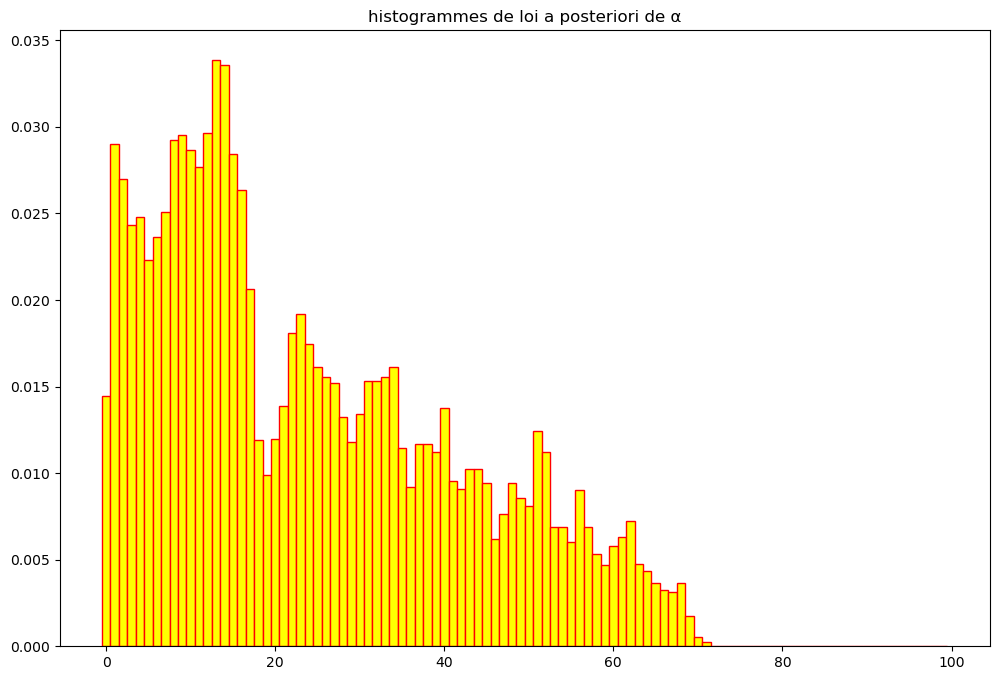

In [786]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(alphaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de α')
plt.show()

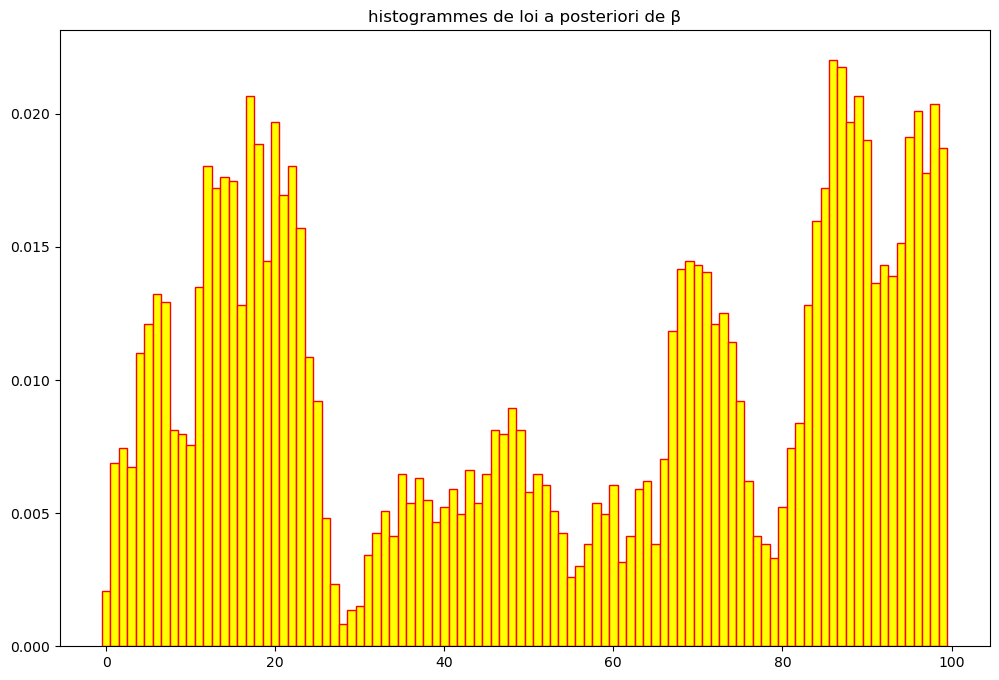

In [787]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(betaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de β')
plt.show()

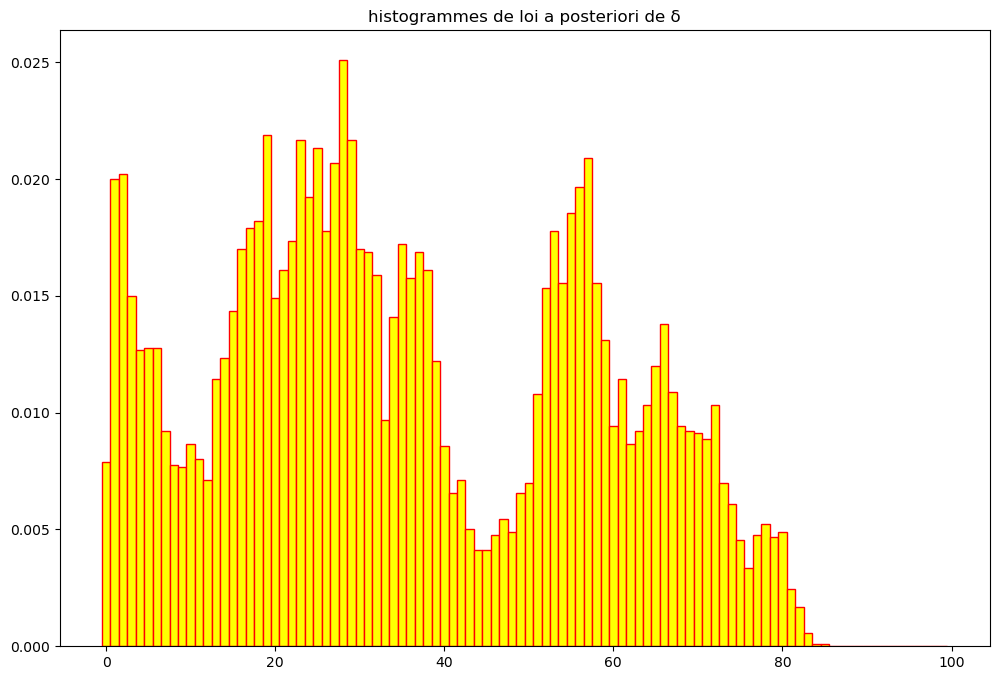

In [788]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(deltaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de δ')
plt.show()

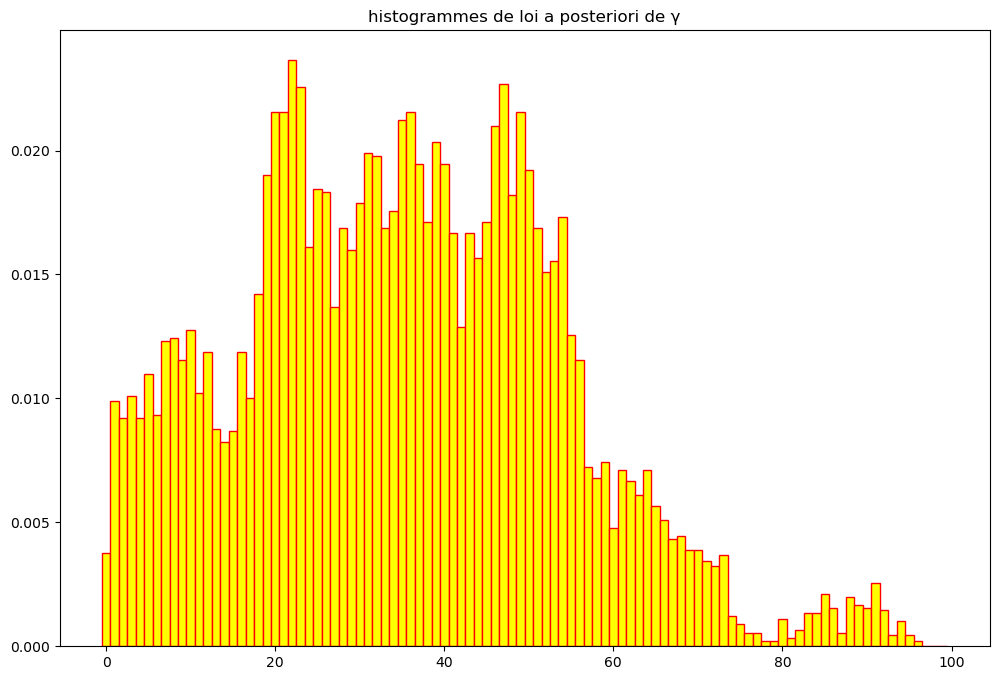

In [789]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(gammaPost,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de γ')
plt.show()

##### verification sur y0 et z0

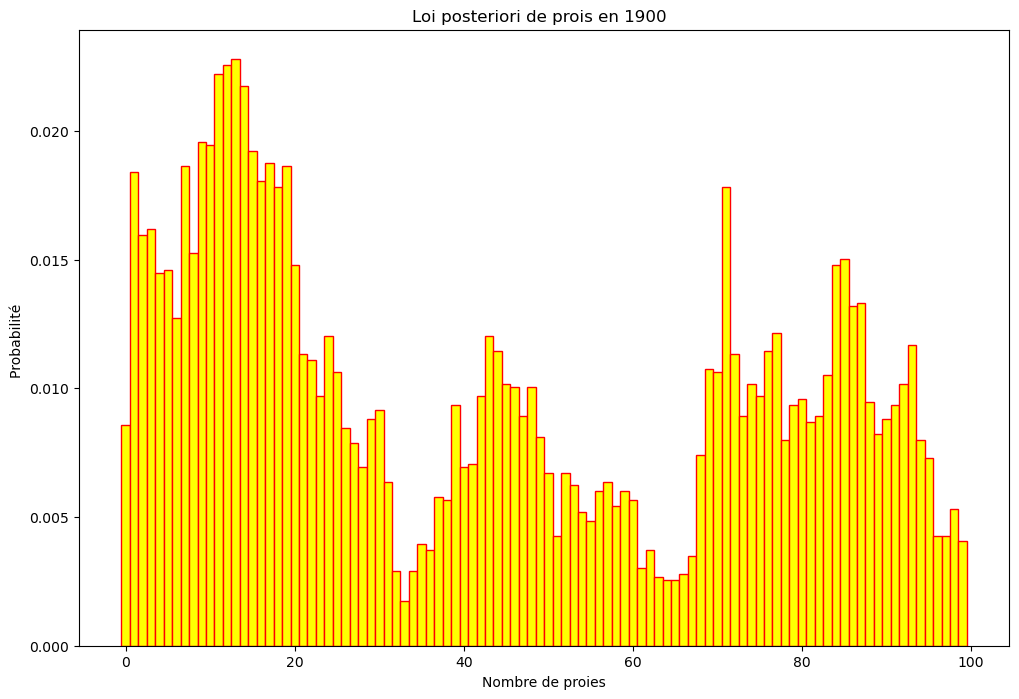

In [790]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(y0Post,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité ')
plt.title('Loi posteriori de prois en 1900  ')
plt.show()

conforme bien avec les données t0=0 ????

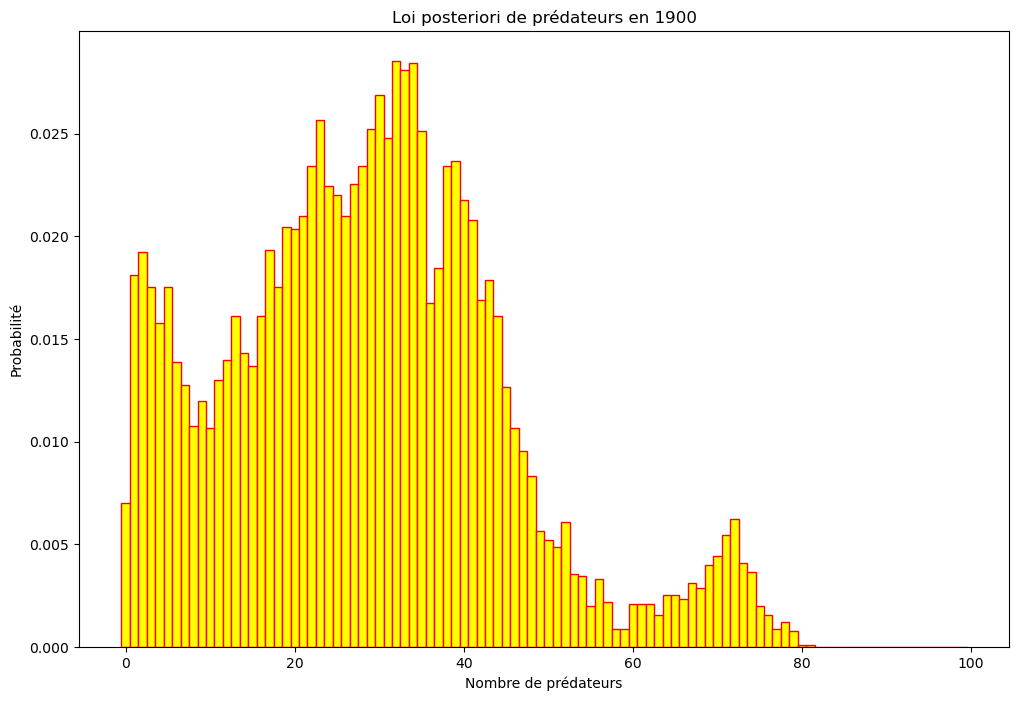

In [791]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(z0Post,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1900')
plt.show()

In [792]:
N=Nsamples-b
dt = 30/(N-1) # pour trouver l'indice de l'année k=année/dt
solution = resolutionSystem1Euler(alphaPost,betaPost,deltaPost,gammaPost,y0Post,z0Post,dt,N)

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/2532034969.py:10: RuntimeWarning: overflow encountered in multiply
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/2532034969.py:11: RuntimeWarning: overflow encountered in multiply
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))


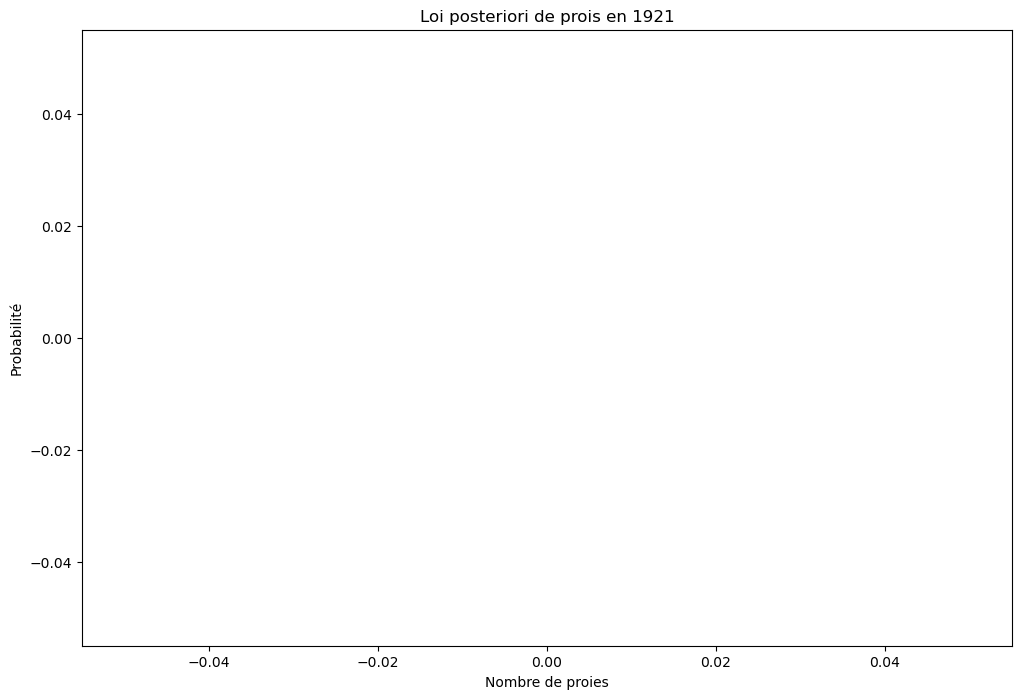

In [793]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[1][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1921')
plt.show()

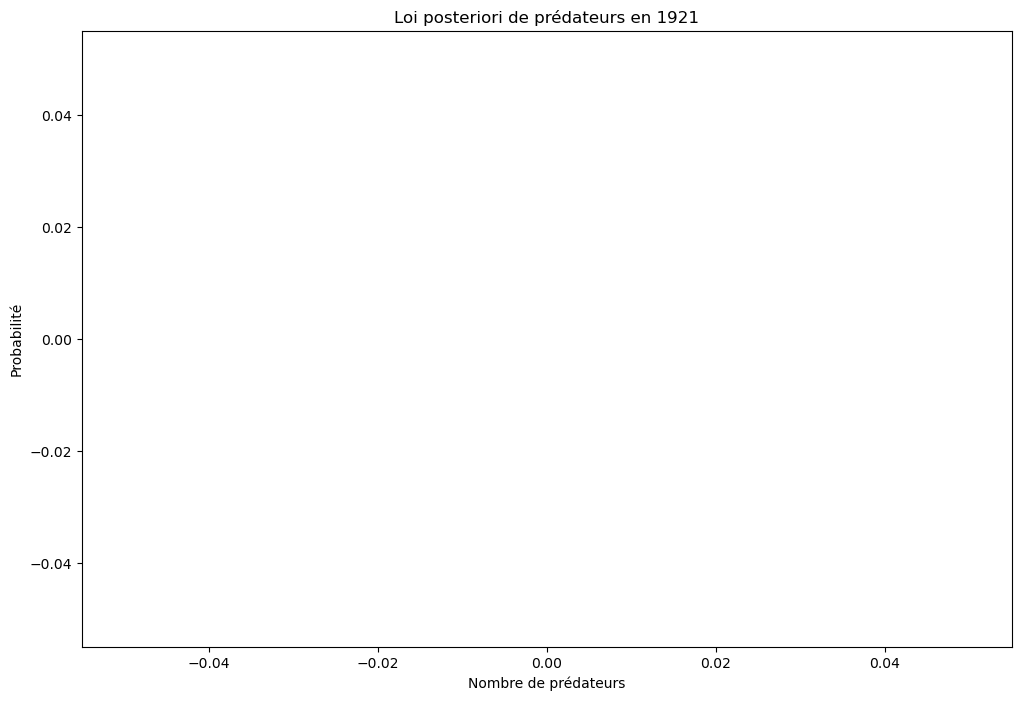

In [775]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[2][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1921')
plt.show()

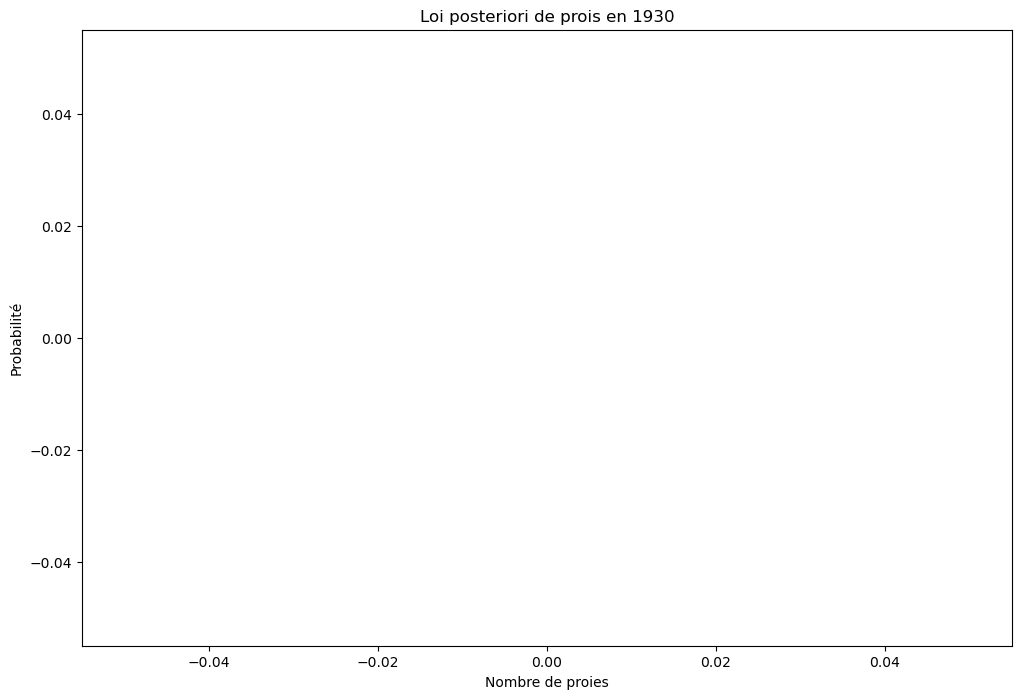

In [776]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[1][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1930')
plt.show()

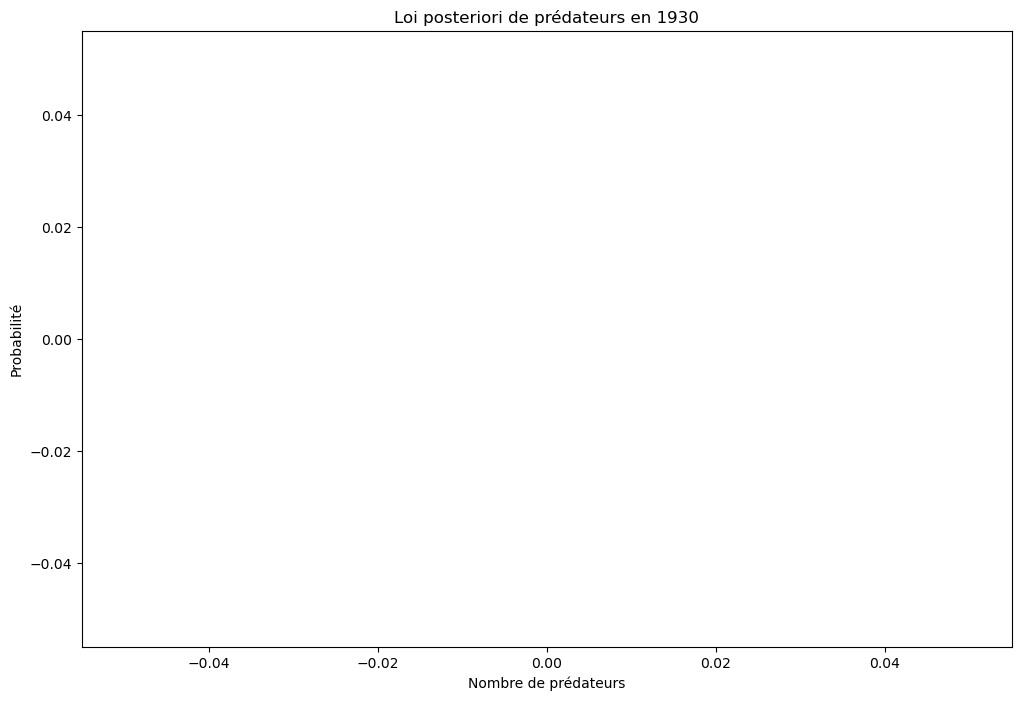

In [777]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solution[2][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1930')
plt.show()


### 4.3 Calibration full-bayésienne

#### Question 7

In [699]:
def fullPosteriori(x,sigmaProie, sigmaPredateur):
    P1 = lognorm.pdf(x=x[6], s=-1, scale=np.exp(1))
    P2 = lognorm.pdf(x=x[7], s=-1, scale=np.exp(1))
    p = vraisemblance(x[:6,], sigmaProie, sigmaPredateur)*prior(x[:6,])*P1*P2
    
    return p

In [707]:
def MetropolisHastingsFull(x0,Nsamples,sigmaOptProie,sigmaOptPredateur):
    L=[]
    x = x0
    for i in range(Nsamples):
        xprim = np.random.multivariate_normal(x,np.identity(np.size(x0)), size=1)
        xprim.shape=(np.size(x0),)
        ro = 0
        if (all(xprim[:6]>0)):
            ro = fullPosteriori(np.array(xprim), sigmaOptProie, sigmaOptPredateur)/fullPosteriori(x, sigmaOptProie, sigmaOptPredateur)
        u = np.random.uniform()
        a=min([1,ro])
        
        if(u<=a):
            x = xprim
        L.append(x)
    return np.array(L)

In [708]:
x0Full = np.concatenate((x_opt,np.array([np.exp(-1),np.exp(-1)])))

In [710]:
## test 
Nsamples =10000
b =100
SamplesXpostFull = MetropolisHastingsFull(x0Full,Nsamples ,sigmaOptProie, sigmaOptPredateur)
SamplesXposFull = SamplesXpostFull[b:,]  ## 

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/2573968066.py:7: RuntimeWarning: invalid value encountered in log
  yresidu = np.log(ypred)-np.log(args[2]) # aproie
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:7: RuntimeWarning: overflow encountered in double_scalars
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:8: RuntimeWarning: overflow encountered in double_scalars
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/2573968066.py:8: RuntimeWarning: invalid value encountered in log
  zresidu = np.log(zpred)-np.log(args[3]) # apreda


In [711]:
alphaPostFull = SamplesXpostFull[:,0]
betaPostFull = SamplesXpostFull[:,1]
deltaPostFull = SamplesXpostFull[:,2]
gammaPostFull = SamplesXpostFull[:,3]
y0PostFull = SamplesXpostFull[:,4]
z0PostFull = SamplesXpostFull[:,5]

In [712]:
bins = [x+ 0.5 for x in range(-1, 100)]

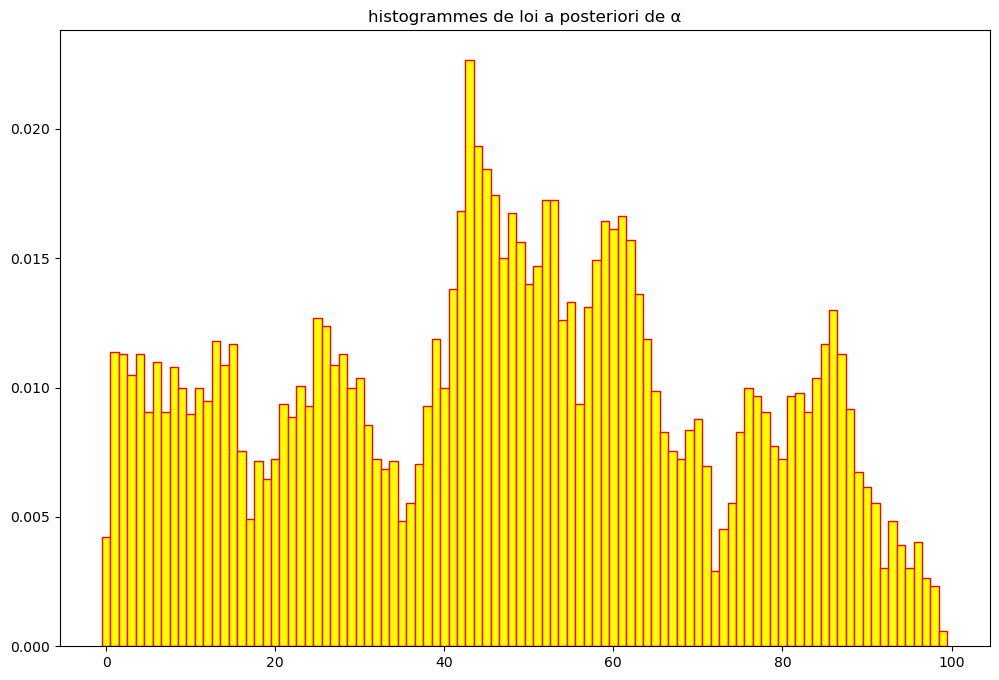

In [713]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(alphaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de α')
plt.show()

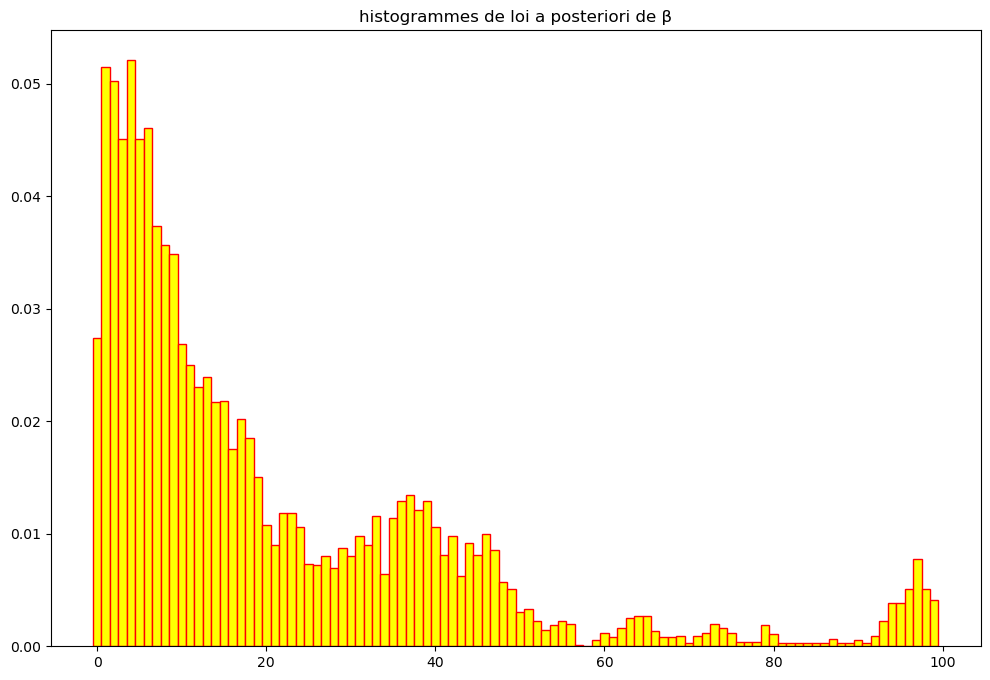

In [714]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(betaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de β')
plt.show()

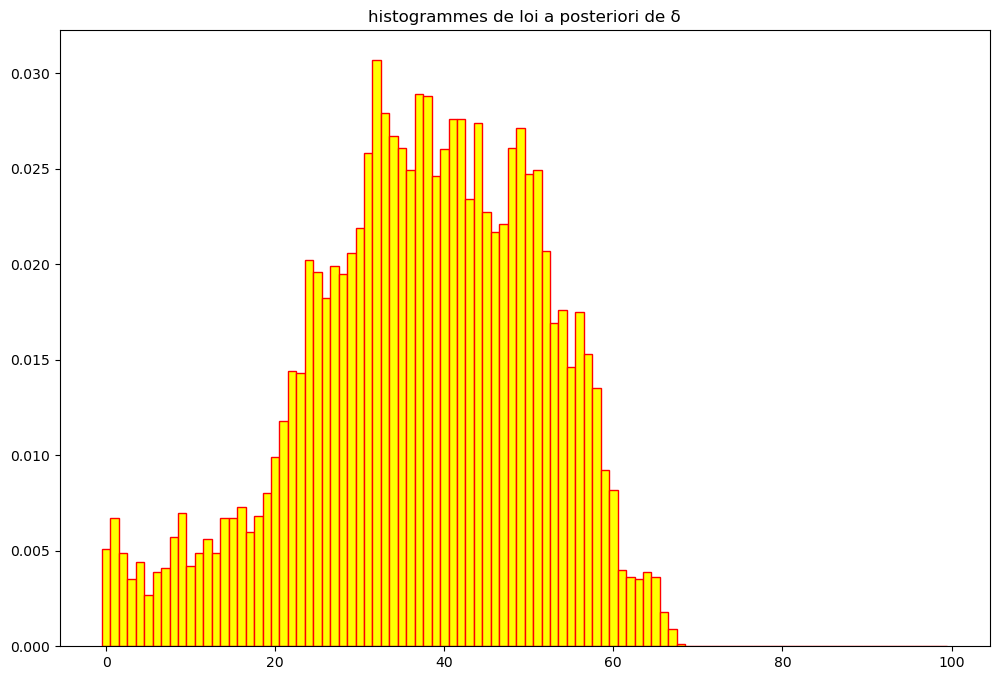

In [716]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(deltaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de δ')
plt.show()

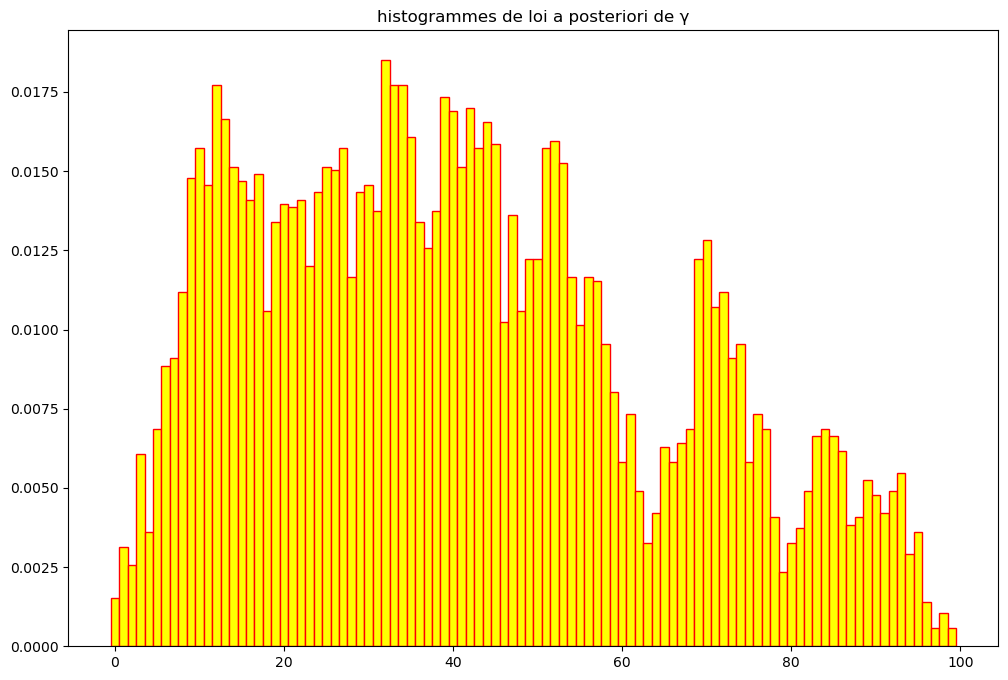

In [717]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(gammaPostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
#plt.xlabel('Nombre de proies')
#plt.ylabel('Probabilité')
plt.title('histogrammes de loi a posteriori de γ')
plt.show()

##### verification sur y0 et z0

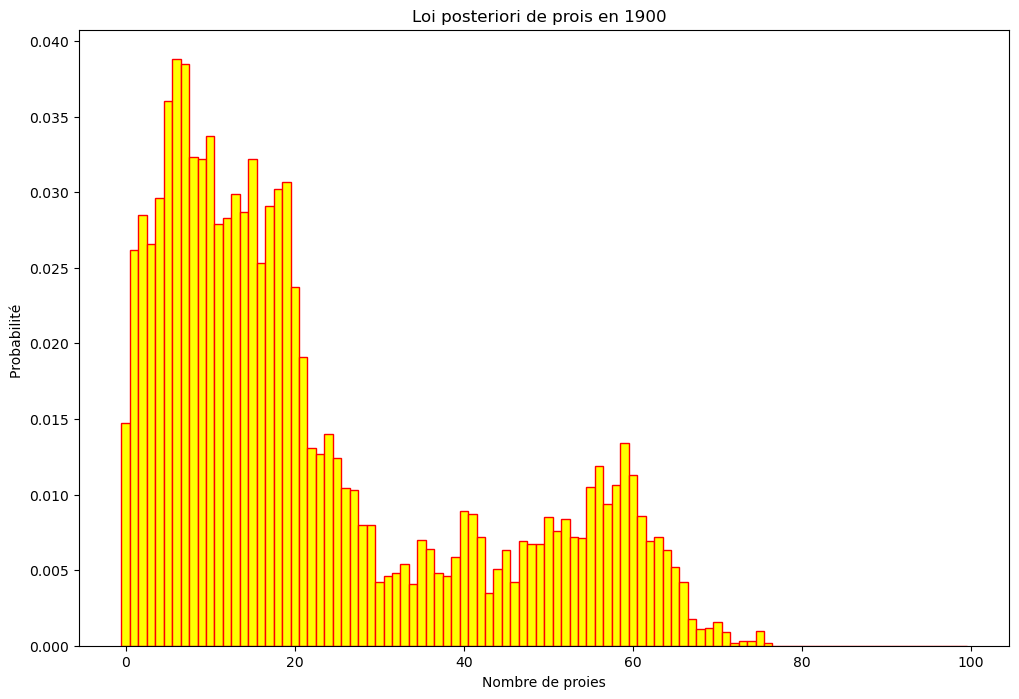

In [718]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(y0PostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité ')
plt.title('Loi posteriori de prois en 1900  ')
plt.show()

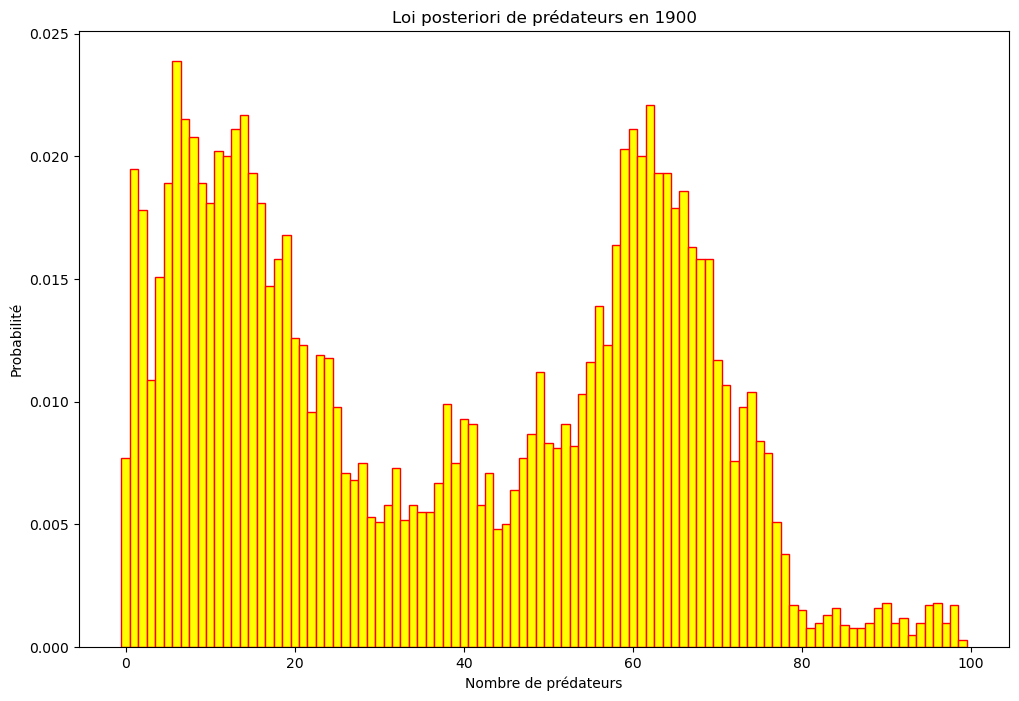

In [719]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(z0PostFull,  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1900')
plt.show()

In [720]:
N = Nsamples-b
dt = 30/(N-1) # pour trouver l'indice de l'année k=année/dt
solutionFull = resolutionSystem1Euler(alphaPostFull,betaPostFull,deltaPostFull,gammaPostFull,y0PostFull,z0PostFull,dt,N)

/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:7: RuntimeWarning: overflow encountered in multiply
  y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_1346/3583875945.py:8: RuntimeWarning: overflow encountered in multiply
  z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))


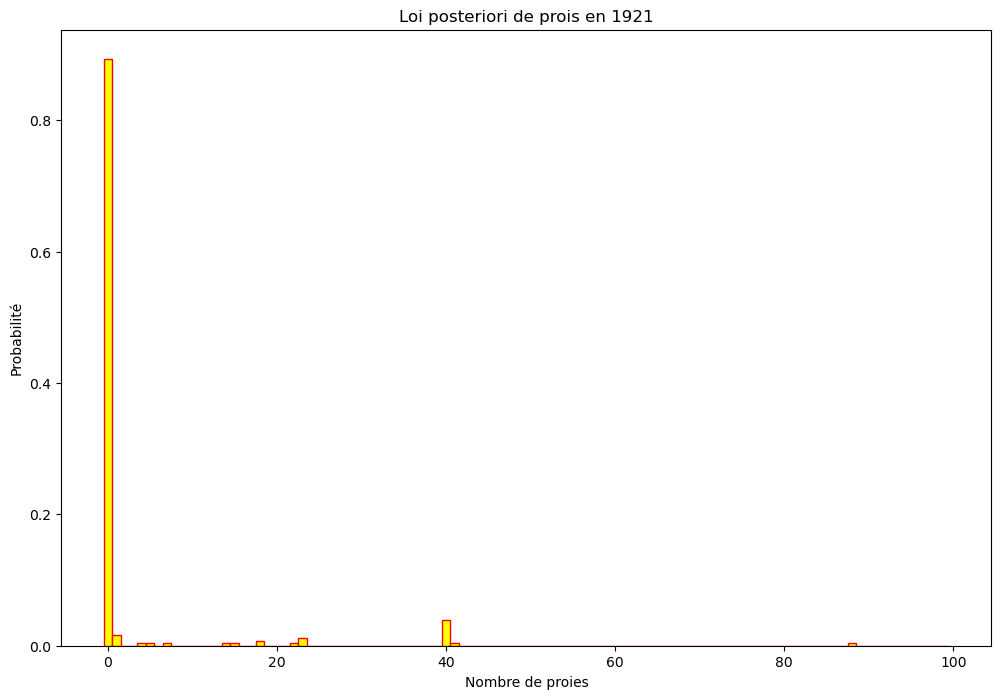

In [721]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[1][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1921')
plt.show()

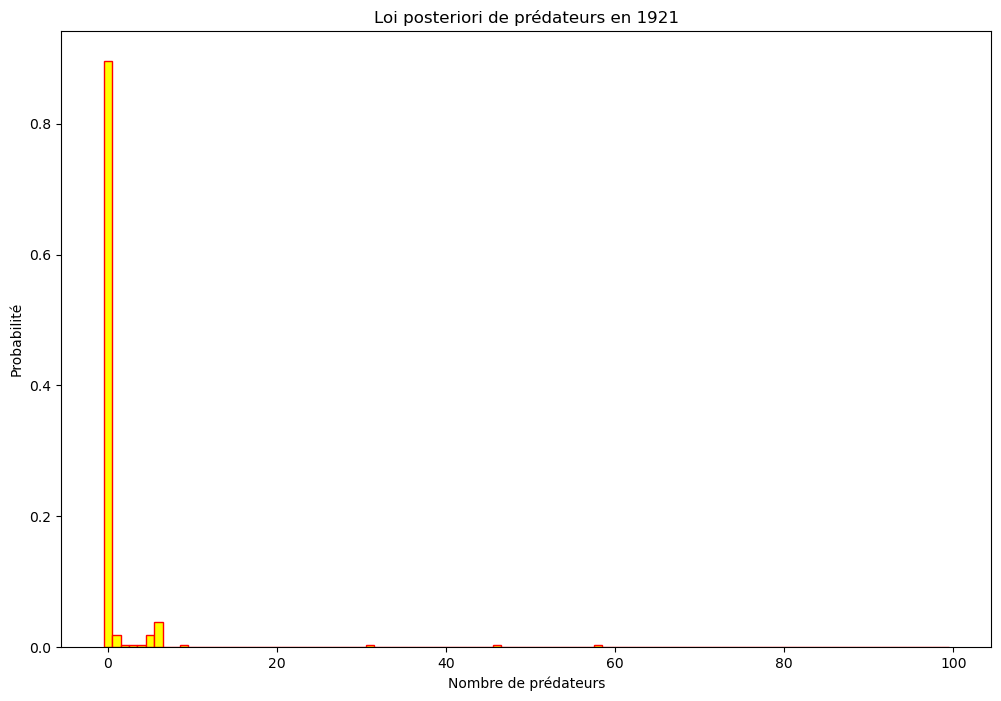

In [722]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[2][int(21/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1921')
plt.show()

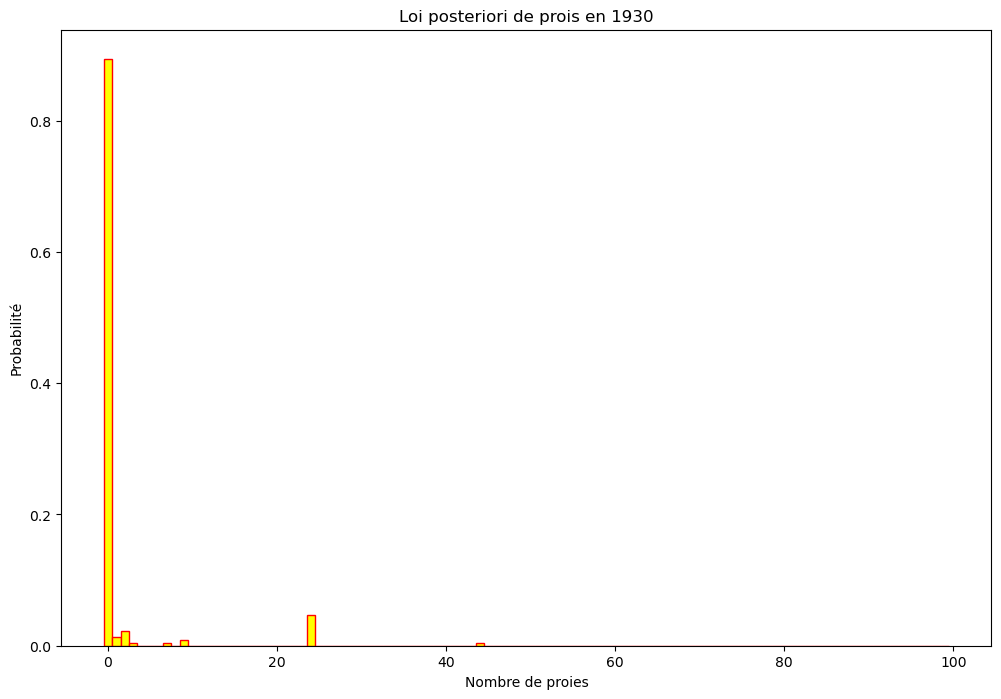

In [723]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[1][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prois en 1930')
plt.show()

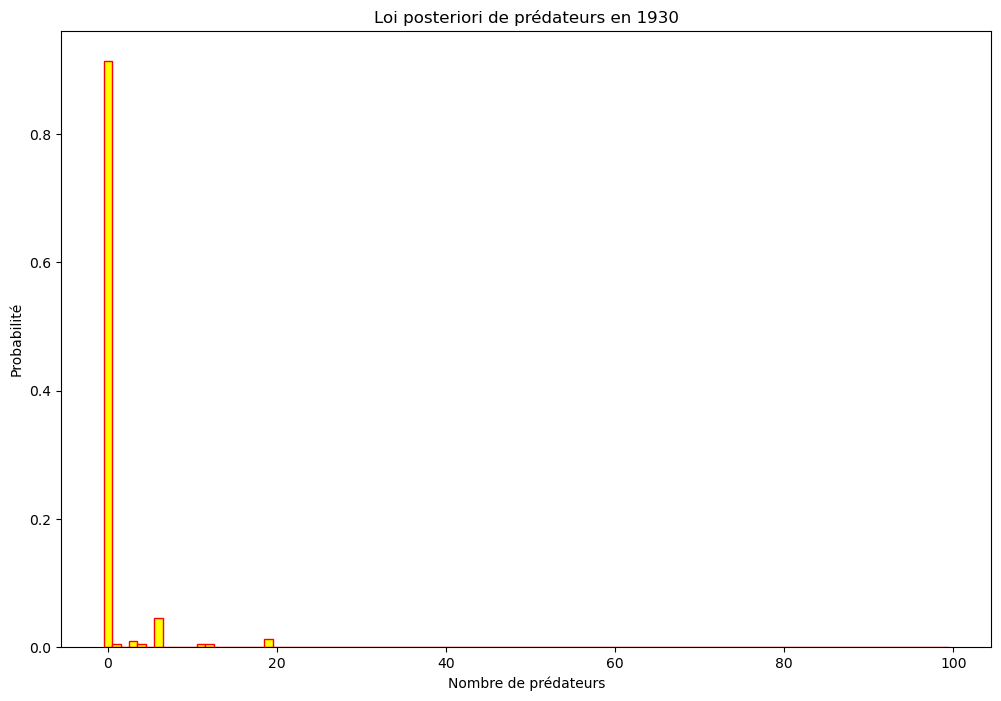

In [724]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(solutionFull[2][int(30/dt)],  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi posteriori de prédateurs en 1930')
plt.show()

## Question 8